# HathiTrust Research Center (HTRC)

The [HathiTrust Digital Library](https://www.hathitrust.org/) contains over 14 million volumes scanned from academic libraries around the world (primarily in North America). The [HathiTrust Research Center](https://analytics.hathitrust.org/) allows researchers to access almost all of those texts in a few different modes for computational text analysis. 

This notebook will walk us through getting set-up to analyze [HTRC Extracted Features](https://wiki.htrc.illinois.edu/display/COM/Extracted+Features+Dataset) for volumes in HathiTrust in a Jupyter/Python environment. *Extracted Features* are currently (as of April 2017) the most robust way to access in-copyright works from the HT Library for computational analysis. 

For more information on HTRC: 
* [Library text mining guide page on HTRC](http://guides.lib.berkeley.edu/c.php?g=491766&p=3381443)
* [Programming Historian's Text Mining in Python through the HTRC Feature Reader](http://programminghistorian.org/lessons/text-mining-with-extracted-features)

## Installation

To start we'll need to install a few things:
* Install the *HTRC Feature Reader* to work with Extracted Features: 
```
conda install -c htrc htrc-feature-reader
``` 
or
```
pip install htrc-feature-reader
pip install matplotlib jupyter
```
* Install Rsync to download Extracted Features from HathiTrust:

  * For linux:
```
yum -y install rsync
```
  * For mac:
```
brew tap homebrew/dupes
brew install rsync
```

## Add volumes from HTRC

### Finding Volume IDs in HathiTrust

To build your own corpus, you will need to find the volume ID for each volume you'd like to include from the [HathiTrust Library](https://www.hathitrust.org/).

* Search for your book, and copy the URL from the *Limited (Search Only)* or *Full View* links under the work. <img src="files/judith-butler-ht.png">
* The final string of characters after the final / is your volume ID
* For example, mdp.39015070698322 is the volume ID for "https://hdl.handle.net/2027/mdp.39015070698322"

### Rsync the volumes

Now that you've identified the volumes you'd like to use, you can run Rsync to pull down their Extracted Features for use with the HTRC Feature Reader.

First, make your way to the directory where you plan to do your work.

If you're planning to analyze only a few volumes you can use the following command, replacing {{volume_id}} with your own:
```
htid2rsync {{volume_id}} | rsync -azv --files-from=- data.sharc.hathitrust.org::features/ local-folder/
```

If you have a file of volume ids, one per line, use --from-file filename, or just -f filename.
```
htid2rsync --f volumeids.txt | rsync -azv --files-from=- data.sharc.hathitrust.org::features/ local-folder/
```

It's also possible to work with the entire library (4TB, so beware):
```
rsync -rv data.analytics.hathitrust.org::features/ .
```

Or to use existing lists of public-domain [fiction](http://data.analytics.hathitrust.org/genre/fiction_paths.txt), [drama](http://data.analytics.hathitrust.org/genre/drama_paths.txt), and [poetry](http://data.analytics.hathitrust.org/genre/poetry_paths.txt) (Underwood 2014).

## Working with the Extracted Features

In the example, below, we'll work with five volumes of the *Congressional Record* using IDs provided by HathiTrust. I've listed those IDs (randomly selected from a much larger list) in the file, cr_ids_5.txt.

Let's download the extracted features for each of those five volumes:


In [50]:
%%bash
htid2rsync --f cr_ids_5.txt | rsync -azv --files-from=- data.sharc.hathitrust.org::features/ local-folder/

[sandbox] Welcome to the HathiTrust Research Center rsync server.

receiving file list ... done

sent 394 bytes  received 953 bytes  207.23 bytes/sec
total size is 9192873  speedup is 6824.70


All of the examples of code below are taken directly, or adapted, from the [Programming Historian tutorial](http://programminghistorian.org/lessons/text-mining-with-extracted-features) or the [FeatureReader's Readme.md file](https://github.com/htrc/htrc-feature-reader).

You'll notice, from the output above, that the content for each volume is stored in a compressed JSON file, in a rather lengthy file directory. We can import and initialize FeatureReader with file paths pointing to the six JSON files (using the paths from the output above):

In [51]:
from htrc_features import FeatureReader
import os
paths = [os.path.join('local-folder', 'chi/pairtree_root/50/17/03/73/50170373/chi.50170373.json.bz2'), 
         os.path.join('local-folder', 'njp/pairtree_root/32/10/10/76/47/62/15/32101076476215/njp.32101076476215.json.bz2'), 
         os.path.join('local-folder', 'uc1/pairtree_root/$c/22/51/89/$c225189/uc1.$c225189.json.bz2'), 
         os.path.join('local-folder', 'uiuo/pairtree_root/ar/k+/=1/39/60/=t/7s/n1/rk/4f/ark+=13960=t7sn1rk4f/uiuo.ark+=13960=t7sn1rk4f.json.bz2'), 
         os.path.join('local-folder', 'uva/pairtree_root/x0/30/51/56/78/x030515678/uva.x030515678.json.bz2')]
fr = FeatureReader(paths)
for vol in fr.volumes():
    print(vol.id, vol.title)

chi.50170373 The Congressional globe.
njp.32101076476215 Congressional record : proceedings and debates of the ... Congress.
uc1.$c225189 Congressional record : proceedings and debates of the ... Congress.
uiuo.ark:/13960/t7sn1rk4f Congressional record : proceedings and debates of the ... Congress.
uva.x030515678 Congressional record : proceedings and debates of the ... Congress.


These are pretty repetitive titles, which makes sense since they are from different volumes of the same serial title, though we can see that a volume of the *Congressional Globe*, an earlier version of the CR, is also included.

Let's try to pull out some more metadata about these titles, using the [Volume object](http://htrc.github.io/htrc-feature-reader/htrc_features/feature_reader.m.html#htrc_features.feature_reader.Volume) in FeatureReader:

In [29]:
#show the HT URL, year, and page count for each volume
for vol in fr.volumes():
    print("URL: %s Year: %s Page count: %s " % (vol.handle_url, vol.year, vol.page_count))

URL: http://hdl.handle.net/2027/chi.50170373 Year: 1835 Page count: 856 
URL: http://hdl.handle.net/2027/njp.32101076476215 Year: 1905 Page count: 544 
URL: http://hdl.handle.net/2027/uc1.$c225189 Year: 1876 Page count: 1040 
URL: http://hdl.handle.net/2027/uiuo.ark:/13960/t7sn1rk4f Year: 9999 Page count: 1498 
URL: http://hdl.handle.net/2027/uva.x030515678 Year: 9999 Page count: 686 


In [31]:
#where were these volumes scanned?
for vol in fr.volumes():
    print("Source institution: %s " % (vol.source_institution))

Source institution: CHI 
Source institution: NJP 
Source institution: UC 
Source institution: UIU 
Source institution: UVA 


In [43]:
vol = fr.first()
tokens = vol.tokens_per_page()
# Show just the first few rows, so we can look at what it looks like
tokens.head()

,count
page,
1,15
2,60
3,0
4,4
5,0


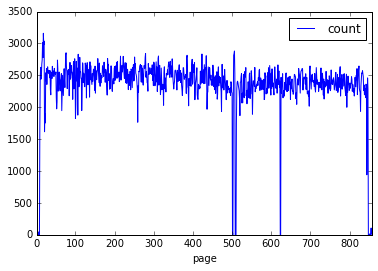

In [35]:
%matplotlib inline
tokens.plot()

Now let's look at some specific pages, using the [Page object in FeatureReader](http://htrc.github.io/htrc-feature-reader/htrc_features/feature_reader.m.html#htrc_features.feature_reader.Page).

In [52]:
i = 0
for page in vol:
    # Same as `for page in vol.pages()`
    i += 1
    if i >= 300:
        break
print(page)

<page 00000300 of volume uva.x030515678>


In [53]:
print("The body has %s lines, %s empty lines, and %s sentences" % (page.line_count(),
                                                                   page.empty_line_count(),
                                                                   page.sentence_count()))


The body has 179 lines, 0 empty lines, and 32 sentences


In [54]:
#look at the first 20 tokens on the page
print(page.tokenlist()[:20])

                                   count
page section token          pos         
300  body    "              ``         1
             &              CC         1
             '              ''         1
                            POS        3
             '-Hi"          JJ         1
             's             POS        2
             'stdration     .          1
             (              -LRB-     13
             )              -RRB-     12
             ,              ,        180
             ,,T,....       NNP        1
             ,...           NNP        1
             ,...}.         ,          1
             ,Georgetown    NNP        1
             ,supplementary NNP        1
             -              :          3
             .              .         32
             ..             CC         1
             ...            :          2
             ......         :          2


In [55]:
df = page.tokenlist(section="header", case=False, pos=False)
print(df)

                            count
page section lowercase           
300  header  298                1
             congressional      1
             index              1
             page               1
             record.            1
             the                1
             to                 1


In [56]:
df = page.tokenlist()
# Slicing on Multiindex: get all Signular or Mass Nouns (NN)
idx = pd.IndexSlice
nouns = df.loc[idx[:,:,:,'NN'],]
print(nouns[:3])
print("With index reset: ")
print(nouns.reset_index()[:2])

                             count
page section token      pos       
300  body    A.         NN       2
             Government NN       1
             Mead       NN       1
With index reset: 
   page section       token pos  count
0   300    body          A.  NN      2
1   300    body  Government  NN      1


In [ ]:
all_vol_token_counts = vol.tokenlist(pos=False, case=False)
print(all_vol_token_counts.loc[idx[:,'body', 'she'],][:3])

In [49]:
a = vol.term_page_freqs()
print(a.loc[10:15,['the','and','is','he', 'she']])
a = vol.term_page_freqs(page_freq=False)
print(a.loc[10:15,['the','and','is', 'he', 'she']])

token  the  and  is  he  she
page                        
10       1    1   0   1    0
11       1    1   0   0    0
12       1    1   0   0    0
13       1    1   1   0    0
14       1    1   0   0    0
15       1    1   0   0    0
token  the  and  is  he  she
page                        
10     134   22   0   1    0
11      93   19   0   0    0
12     124    9   0   0    0
13     114   24   1   0    0
14     100   19   0   0    0
15      78   11   0   0    0
